In [1]:
# import numpy as np
# import torch.nn as nn

from library import *
import torchvision 
from torchvision import transforms


c:\Users\matth\OneDrive - ECAM\Documents\Cours ECAM\5MIN\Q1 23-24\Projet IA\Unsupervised_Learning_Encoders\library.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm #Progress bar


In [2]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 3 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

In [3]:
mse_loss = nn.MSELoss() #Original loss function

In [4]:

# This is useful for training autoencoders, 
# which are a type of neural network that are trained to reproduce their input data as output.

class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label. 

In [5]:
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [6]:
def getLayer (in_size, out_size):
    """
    in_size: number of input neurons/features
    out_size: number of output neurons
    """

    return nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU())


In [7]:
auto_encoder = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D//2),
    getLayer(D//2, D//3),
    getLayer(D//3, D//4),
    nn.Linear(D//4, n), 
    ) 

auto_decoder = nn.Sequential(
    getLayer(n, D//4),
    getLayer(D//4, D//3),
    getLayer(D//3, D//2),
    nn.Linear(D//2, D),
    View (-1, 1, 28, 28)
)

auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)


In [8]:
train_network(auto_encode_decode, mse_loss, train_loader, test_loader=test_loader, epochs=5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,26.627540,0.045381,0.038103
1,1,53.000956,0.037887,0.035707
2,2,81.839087,0.036141,0.034311
3,3,122.413484,0.035113,0.033632
4,4,174.873456,0.034379,0.032865


In [9]:
def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset, and `labels` are the original labels provided by the `dataset_to_encode`
    """
    #Create space to store the results
    projected = []
    labels = []
    #Switch to eval mode
    encoder = encoder.eval()
    #Switching to CPU mode for simplicty, but you don't have to. 
    encoder = encoder.cpu()
    with torch.no_grad():#We don't want to train, so torch.no_grad! 
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) #encode the original data
            projected.append( z.numpy() ) #store the encoded version & label
            labels.append( y.cpu().numpy().ravel() )
    #Turn the results into single large numpy arrays
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    #return the results
    return projected, labels

<Axes: >

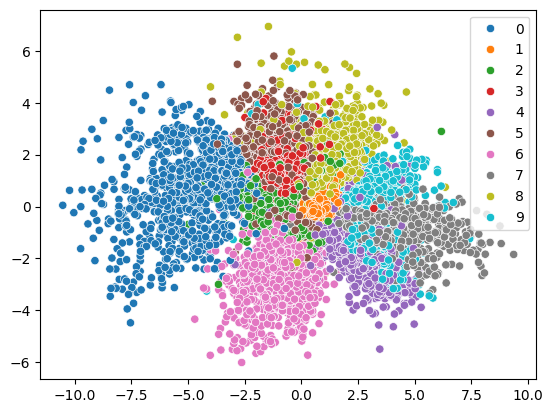

In [10]:
projected, labels = encode_batch(auto_encoder, test_data_xy)
sns.scatterplot(x=projected[:,0], y=projected[:,1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")

In [15]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(projected[:,0], projected[:,1], projected[:,2], c=labels, cmap='viridis')

# Produce a legend for the ranking (colors). 
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

plt.show()

<IPython.core.display.Javascript object>